In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as func
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchsummary import summary

In [2]:
torch.manual_seed(666)

# Dataset

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=0.5,
        std=0.5
    )
])

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:09<00:00, 2713281.96it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 944083.85it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2776007.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4963741.84it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training

Обучим линейный генератор для датасета fashionMnist

In [5]:
class Generator(nn.Module):
    def __init__(self, nz, hidden_dim=32, output_size=28*28):
        super().__init__()
        
        self.gen = nn.Sequential(
            nn.Linear(nz, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*4, output_size),
            nn.Tanh(),
        )
        
    
    def forward(self, x):
        x = self.gen(x)
        return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, hidden_dim=32, output_size=1):
        super().__init__()
        self.input_size = input_size

        self.disc = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
        )
        
        self.classifier = nn.Linear(hidden_dim*2, output_size)
        
        self.act = nn.Sigmoid()


    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.disc(x)

        x = self.classifier(x)
        x = self.act(x)
        return x

In [7]:
summary(Discriminator(), (1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
         LeakyReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
         LeakyReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
           Sigmoid-8                    [-1, 1]               0
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [8]:
def _train_generator(batch, gen, disc, nz, gen_loss, gen_opt, device):
    gen_opt.zero_grad()

    noise = torch.randn(batch.shape[0], 1, nz, device=device)
    fake_img = gen(noise)    
    fake_preds = disc(fake_img)
    targets = torch.ones(batch.shape[0], 1, device=device)

    g_loss = gen_loss(fake_preds, targets)
    g_loss.backward()
    gen_opt.step()

    return g_loss

In [9]:
def _train_discriminator(batch, gen, disc, nz, disc_loss, disc_opt, device):
    #training discriminator
    disc_opt.zero_grad()

    real_preds = disc(batch)
    real_targets = 0.9 * torch.ones(batch.shape[0], 1, device=device)
    real_loss = disc_loss(real_preds, real_targets)
    
    #generate fake images
    noise = torch.randn(batch.shape[0], 1, nz, device=device)
    fake_img = gen(noise)

    fake_preds = disc(fake_img)
    fake_targets = torch.zeros(batch.shape[0], 1, device=device)
    fake_loss = disc_loss(fake_preds, fake_targets)

    d_loss = real_loss + fake_loss
    d_loss.backward()
    disc_opt.step()

    return real_loss, fake_loss, d_loss

In [10]:
def _count_scores(real_loss, fake_loss):
    real_score = real_loss.mean().item()
    fake_score = fake_loss.mean().item()
    return real_score, fake_score

In [11]:
def train_gan(gen, gen_loss, gen_opt,
              disc, disc_loss, disc_opt,
              dataloader, device='cpu', epochs=1, nz=32):
    print(device)
    device = torch.device(device)
    
    gen.train()
    disc.train()
    
    gen_loss.to(device)
    disc_loss.to(device)
    
    gen.to(device)
    disc.to(device)
    
    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):

        losses_d_running = []
        losses_g_running = []
        real_scores_running = []
        fake_scores_running = []
        
        for index, batch in enumerate(tqdm(dataloader)):
            input_, _ = batch

            input_ = input_.to(device)

            real_loss, fake_loss, d_loss = _train_discriminator(
                input_,
                gen=gen,
                disc=disc,
                nz=nz,
                disc_loss=disc_loss,
                disc_opt=disc_opt,
                device=device, 
            )

            losses_d_running.append(d_loss.item())

            real_score, fake_score = _count_scores(real_loss, fake_loss)

            
            real_scores_running.append(real_score)
            fake_scores_running.append(fake_score)
            
            if index % 4 == 0:
                #training generator
                g_loss = _train_generator(
                    input_,
                    gen=gen,
                    disc=disc,
                    nz=nz,
                    gen_loss=gen_loss,
                    gen_opt=gen_opt,
                    device=device, 
                )

                losses_g_running.append(g_loss.item())
        
        losses_g.append(np.mean(losses_g_running))
        losses_d.append(np.mean(losses_d_running))
        real_scores.append(np.mean(real_scores_running))
        fake_scores.append(np.mean(fake_scores_running))
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1])
        )
    return losses_g, losses_d, real_scores, fake_scores

In [12]:
gen_loss = nn.BCELoss()
disc_loss = nn.BCELoss()

device = 'mps'

In [13]:
hidden_dim = 32
nz = 32
epochs = 15

disc = Discriminator(hidden_dim=hidden_dim)
gen = Generator(nz, hidden_dim=hidden_dim)

disc_optim = torch.optim.Adam(disc.parameters(), lr=1*10e-4)
gen_optim = torch.optim.Adam(gen.parameters(), lr=1*10e-4)

In [ ]:
g_loss, d_loss, real_score, fake_score = train_gan(
    gen, gen_loss, gen_optim,
    disc, disc_loss, disc_optim,
    dataloader, device, epochs=epochs, nz=nz,
    )

mps


100%|██████████| 1875/1875 [00:21<00:00, 86.29it/s]


Epoch [1/15], loss_g: 7.1022, loss_d: 0.3694, real_score: 0.3469, fake_score: 0.0225


100%|██████████| 1875/1875 [00:20<00:00, 90.15it/s]


Epoch [2/15], loss_g: 6.3112, loss_d: 0.3645, real_score: 0.3552, fake_score: 0.0094


 18%|█▊        | 341/1875 [00:04<00:17, 88.37it/s]

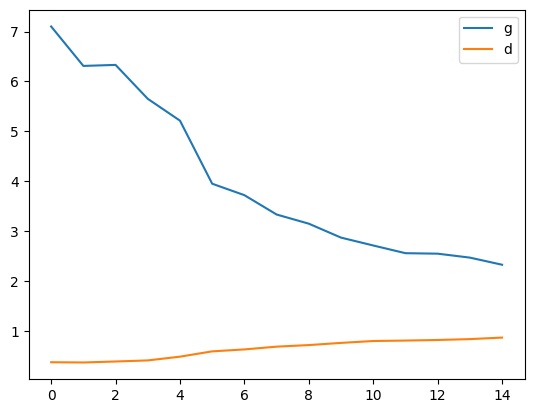

In [16]:
plt.plot(g_loss, label = 'gen loss')
plt.plot(d_loss, label = 'disc loss')
plt.legend()
plt.show()

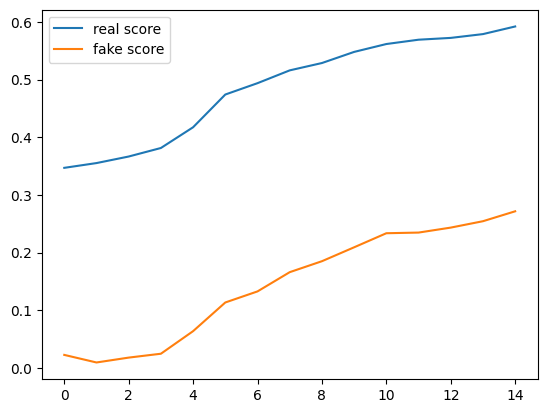

In [17]:
plt.plot(real_score, label = 'real score')
plt.plot(fake_score, label = 'fake score')
plt.legend()
plt.show()

In [18]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

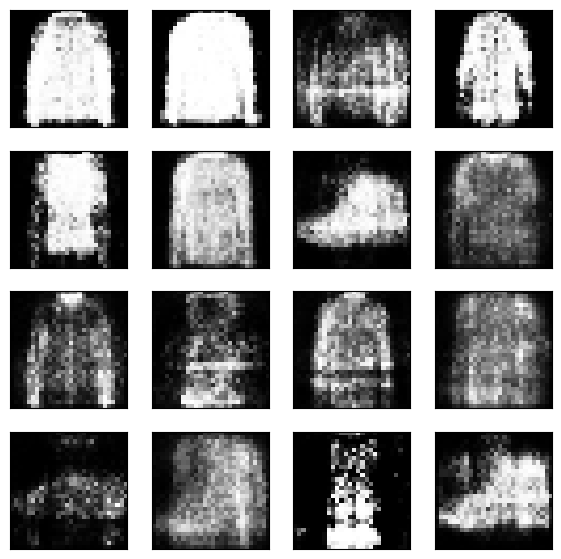

In [19]:
sample_size = 16
fixed_z = torch.randn(1, sample_size, nz, device=device)

with torch.no_grad():

    samples = gen(fixed_z)
    view_samples(-1, samples)

Наш GAN прекрасно обучился! Посмотрим, как выглядит "схлопнувшийся" GAN:

![collapse]("/seminars/seminar_3/gan-collapse.jpg")

# CGAN

In [20]:
class Generator(nn.Module):
    def __init__(self, nz, classes=10, hidden_dim=32, output_size=28*28):
        super().__init__()
        self.classes = classes
        
        self.gen = nn.Sequential(
            nn.Linear(nz + classes, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*4, output_size),
            nn.Tanh(),
        )
        
    
    def forward(self, x, label):
        oh = func.one_hot(label, num_classes=self.classes)
        inp = torch.cat([x, oh], dim=1)
        out = self.gen(inp)
        return out

In [21]:
class Discriminator(nn.Module):
    def __init__(self, classes=10, input_size=28*28, hidden_dim=32, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.classes = classes

        self.disc = nn.Sequential(
            nn.Linear(input_size + classes, hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
        )
        
        self.classifier = nn.Linear(hidden_dim*2, output_size)
        
        self.flatten = nn.Flatten()
        self.act = nn.Sigmoid()


    def forward(self, x, label):
        oh = func.one_hot(label, num_classes=self.classes)
        x = x.view(-1, self.input_size)

        inp = torch.cat([x, oh], dim=1)
        inp = self.disc(inp)

        inp = self.classifier(inp)
        inp = self.act(inp)
        return inp

In [22]:
def _train_cgenerator(batch, labels, gen, disc, nz, gen_loss, gen_opt, device):
    gen_opt.zero_grad()

    noise = torch.randn(batch.shape[0], nz, device=device)
    fake_img = gen(noise, labels)    
    fake_preds = disc(fake_img, labels)
    targets = torch.ones(batch.shape[0], 1, device=device)

    g_loss = gen_loss(fake_preds, targets)
    g_loss.backward()
    gen_opt.step()

    return g_loss

In [23]:
def _train_cdiscriminator(batch, labels, gen, disc, nz, disc_loss, disc_opt, device):
    #training discriminator
    disc_opt.zero_grad()

    real_preds = disc(batch, labels)
    real_targets = 0.9 * torch.ones(batch.shape[0], 1, device=device)
    real_loss = disc_loss(real_preds, real_targets)
    
    #generate fake images
    noise = torch.randn(batch.shape[0], nz, device=device)
    fake_img = gen(noise, labels)

    fake_preds = disc(fake_img, labels)
    fake_targets = torch.zeros(batch.shape[0], 1, device=device)
    fake_loss = disc_loss(fake_preds, fake_targets)

    d_loss = real_loss + fake_loss
    d_loss.backward()
    disc_opt.step()

    return real_loss, fake_loss, d_loss

In [24]:
def train_cgan(gen, gen_loss, gen_opt,
              disc, disc_loss, disc_opt,
              dataloader, device='cpu', epochs=1, nz=32):
    print(device)
    device = torch.device(device)
    
    gen.train()
    disc.train()
    
    gen_loss.to(device)
    disc_loss.to(device)
    
    gen.to(device)
    disc.to(device)
    
    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):

        losses_d_running = []
        losses_g_running = []
        real_scores_running = []
        fake_scores_running = []
        
        for index, batch in enumerate(tqdm(dataloader)):
            input_, labels = batch

            input_ = input_.to(device)
            labels = labels.to(device)

            real_loss, fake_loss, d_loss = _train_cdiscriminator(
                input_,
                labels,
                gen=gen,
                disc=disc,
                nz=nz,
                disc_loss=disc_loss,
                disc_opt=disc_opt,
                device=device, 
            )

            losses_d_running.append(d_loss.item())

            real_score, fake_score = _count_scores(real_loss, fake_loss)

            
            real_scores_running.append(real_score)
            fake_scores_running.append(fake_score)
            
            if index % 4 == 0:
                #training generator
                g_loss = _train_cgenerator(
                    input_,
                    labels,
                    gen=gen,
                    disc=disc,
                    nz=nz,
                    gen_loss=gen_loss,
                    gen_opt=gen_opt,
                    device=device, 
                )

                losses_g_running.append(g_loss.item())
        
        losses_g.append(np.mean(losses_g_running))
        losses_d.append(np.mean(losses_d_running))
        real_scores.append(np.mean(real_scores_running))
        fake_scores.append(np.mean(fake_scores_running))
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1])
        )
    return losses_g, losses_d, real_scores, fake_scores

In [25]:
cgen_loss = nn.BCELoss()
cdisc_loss = nn.BCELoss()

device = 'mps'

In [26]:
hidden_dim = 32
nz = 32
epochs=15

cdisc = Discriminator(hidden_dim=hidden_dim)
cgen = Generator(nz, hidden_dim=hidden_dim)

cdisc_optim = torch.optim.Adam(cdisc.parameters(), lr=1*10e-4)
cgen_optim = torch.optim.Adam(cgen.parameters(), lr=1*10e-4)

In [27]:
g_loss, d_loss, real_score, fake_score = train_cgan(
    cgen, cgen_loss, cgen_optim,
    cdisc, cdisc_loss, cdisc_optim,
    dataloader, device, epochs=epochs, nz=nz,
    )

mps


100%|██████████| 1875/1875 [00:24<00:00, 77.18it/s]


Epoch [1/15], loss_g: 7.3530, loss_d: 0.3686, real_score: 0.3496, fake_score: 0.0189


100%|██████████| 1875/1875 [00:22<00:00, 81.91it/s]


Epoch [2/15], loss_g: 6.5836, loss_d: 0.3614, real_score: 0.3528, fake_score: 0.0087


100%|██████████| 1875/1875 [00:23<00:00, 79.16it/s]


Epoch [3/15], loss_g: 6.5647, loss_d: 0.3696, real_score: 0.3573, fake_score: 0.0123


100%|██████████| 1875/1875 [00:23<00:00, 78.62it/s]


Epoch [4/15], loss_g: 5.9911, loss_d: 0.4092, real_score: 0.3809, fake_score: 0.0282


100%|██████████| 1875/1875 [00:24<00:00, 76.62it/s]


Epoch [5/15], loss_g: 5.1828, loss_d: 0.4834, real_score: 0.4209, fake_score: 0.0624


100%|██████████| 1875/1875 [00:25<00:00, 73.84it/s]


Epoch [6/15], loss_g: 4.5124, loss_d: 0.5364, real_score: 0.4478, fake_score: 0.0886


100%|██████████| 1875/1875 [00:25<00:00, 74.10it/s]


Epoch [7/15], loss_g: 3.8803, loss_d: 0.5964, real_score: 0.4772, fake_score: 0.1192


100%|██████████| 1875/1875 [00:24<00:00, 76.34it/s]


Epoch [8/15], loss_g: 3.5565, loss_d: 0.6561, real_score: 0.5020, fake_score: 0.1541


100%|██████████| 1875/1875 [00:23<00:00, 79.75it/s]


Epoch [9/15], loss_g: 3.1542, loss_d: 0.7159, real_score: 0.5305, fake_score: 0.1853


100%|██████████| 1875/1875 [00:24<00:00, 77.67it/s]


Epoch [10/15], loss_g: 3.0195, loss_d: 0.7345, real_score: 0.5364, fake_score: 0.1981


100%|██████████| 1875/1875 [00:23<00:00, 78.16it/s]


Epoch [11/15], loss_g: 2.7828, loss_d: 0.7678, real_score: 0.5524, fake_score: 0.2154


100%|██████████| 1875/1875 [00:24<00:00, 78.07it/s]


Epoch [12/15], loss_g: 2.8580, loss_d: 0.7560, real_score: 0.5476, fake_score: 0.2084


100%|██████████| 1875/1875 [00:24<00:00, 75.41it/s]


Epoch [13/15], loss_g: 2.6107, loss_d: 0.8068, real_score: 0.5688, fake_score: 0.2381


100%|██████████| 1875/1875 [00:23<00:00, 78.83it/s]


Epoch [14/15], loss_g: 2.4574, loss_d: 0.8372, real_score: 0.5822, fake_score: 0.2550


100%|██████████| 1875/1875 [00:24<00:00, 77.54it/s]

Epoch [15/15], loss_g: 2.2536, loss_d: 0.8836, real_score: 0.5979, fake_score: 0.2857


In [ ]:
plt.plot(g_loss, label = 'gen loss')
plt.plot(d_loss, label = 'disc loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(real_score, label = 'real score')
plt.plot(fake_score, label = 'fake score')
plt.legend()
plt.show()

In [32]:
# helper function for viewing a list of passed in sample images
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

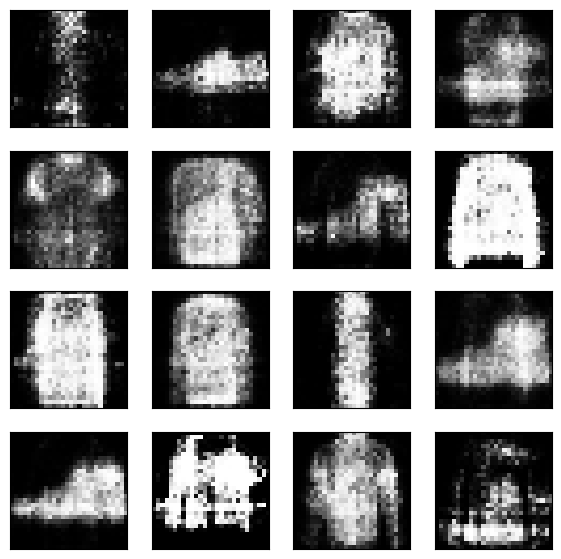

In [35]:
sample_size = 16
fixed_z = torch.randn(sample_size, nz, device=device)
y = torch.tensor(np.random.randint(0, 10, size=(sample_size)))

with torch.no_grad():
    fixed_z = fixed_z.to('mps')
    y = y.to('mps')
    samples = cgen(fixed_z, y)
    view_samples(samples)